<h2>개인 구글 드라이브와 colab 연동 </h2>

샘플링과 라벨링 코드는 다른 파일에서 작업하여 week6_labeling_202014190_임지수.ipynb 로 따로 올렸습니다.

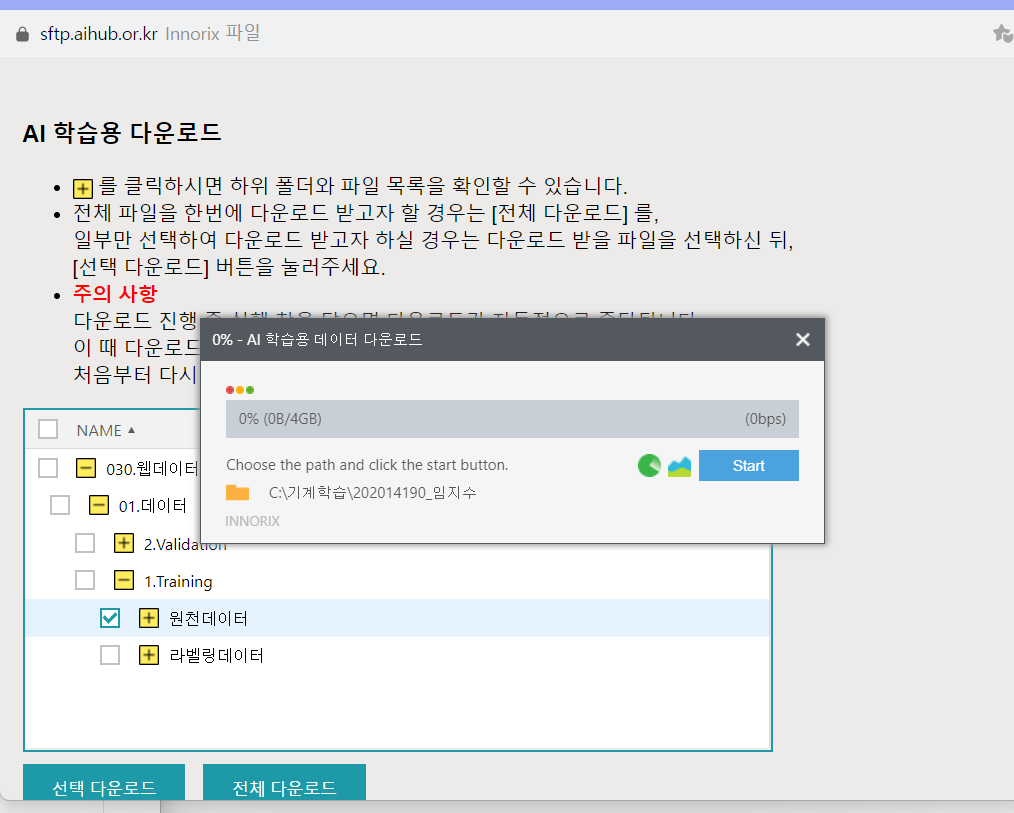

In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


<h2>라이브러리 설치 </h2>

In [39]:
!pip install scikit-learn==0.23.1 # !는 로컬 컴퓨터에서 실행해라, 구글 colab에서는 유지를 시켜주지 않아서 시간 지나면 삭제됨
!pip install sklearn-crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<pre>
<h2> 1. "spacing_data.txt"로 부터 데이터를 읽고 datas에 저장 </h2>
  1.1 입력 데이터 형태
    예시) 나 는 사 과 가 좋 아 \t B I B I I B I
    
    "나는 사과가 좋아" 라는 문장이 있을 때, 공백을 기준으로 나눈 "나는", "사과가", "좋아"를 각각 어절이라고 함
    각 어절의 시작음절을 "B"로 나머지를 "I"로 태깅하였고 문장과 라벨을 \t으로 구분해놓은 상태

  1.2 데이터 변환

    입력 데이터를 읽고 탭을 기준으로 문장과 라벨을 분리
    문장을 공백을 기준으로 나눈다
      예시)"나 는 사 과 가 좋 아" -> ["나", "는", "사", "과", "가", "좋", "아"]
    문장과 라벨을 튜플형태로 datas 리스트에 넣는다
    datas = [ ( ["나", "는", "사", "과", "가", "좋", "아"], ["B", "I", "B", "I", "I", "B", "I"] ), ( ... ), ... ]
    
<h2> 2. 전체 데이터를 9:1 비율에 맞추어 학습, 평가 데이터로 나누기 </h2>
  2.1 train_datas 리스트와 test_datas 리스트에 나누어 저장
</pre>

In [40]:
import os
import sklearn_crfsuite
from sklearn_crfsuite import metrics


# sequence labeling problem == 순차적(신차열) 표지 부착 문제
# 현재 sequence에서 classification하고 다음 sequence에서 classificaction하고 이거를 쭉 레이블링
# 보통 출력은 BIO 노테이션을 사용하고 오늘 쓰는 건 BI 노테이션 (띄어쓰기 문제 풀 때 주로 사용)
# 어디부터 어디까지를 끊어내기 위한 노테이션 방법
# B: Beginner, I: Inner, O: Outer
# 음절 띄어쓰기에는 O가 필요없으므로 BI만 사용

# 파일 경로
file_path = "/gdrive/My Drive/colab/crf/sampling_text_fin.txt"

# "spacing_data.txt" 파일을 읽고 lines에 읽은 데이터를 저장
with open(file_path, "r", encoding="utf8") as inFile:
    lines = inFile.readlines()

# 데이터를 음절로 이루어진 문장과 정답 값으로 나누어 저장
datas = []
# 이곳을 채우세요.
for line in lines:
  pieces = line.strip().split("\t") # 한 라인을 읽고 탭으로 분류
  eumjeol_sequence, label = pieces[0].split(), pieces[1].split() # 음절열과 레이블이 각각 들어감
  datas.append((eumjeol_sequence, label))
    
number_of_train_datas = int(len(datas)*0.9)

train_datas = datas[:number_of_train_datas]
test_datas = datas[number_of_train_datas:]
          
print("train_datas 개수 : " + str(len(train_datas)))   # 트레이닝 셋:90퍼        
print("test_datas 개수 : " + str(len(test_datas))) # 테스트 셋:10퍼

# dnn의 장점은 feature를 자동으로 찾아준다

train_datas 개수 : 9000
test_datas 개수 : 1000


<pre>
<h2> 1. 문장의 각 음절을 crf 모델의 입력으로 사용 할 수 있도록 자질화 </h2>
  "BOS" : 시작 음절인지 여부
  "EOS" : 마지막 음절인지 여부
  "WORD" : 기준 음절
  "IS_DIGIT" : 기준 음절이 숫자인지 여부
  "-1_WORD" : 기준 음절의 왼쪽 첫번째 음절
  "-2_WORD" : 기준 음절의 왼쪽 두번째 음절
  "+1_WORD" : 기준 음절의 오른쪽 첫번째 음절
  "+2_WORD" : 기준 음절의 오른쪽 두번째 음절

  1.1 예시) ["나", "는", "사", "과", "가", "좋", "아"]
            ->
            [ { "BOS":True, "EOS":False, "WORD":"나", "IS_DIGIT":False, "+1_WORD":"는", "+2_WORD":"사" },
    { "BOS":False, "EOS":False, "WORD":"는", "IS_DIGIT":False, "-1_WORD":"나", "+1_WORD":"사", "+2_WORD":"과" },
    { "BOS":False, "EOS":False, "WORD":"사", "IS_DIGIT":False, "-2_WORD":"나", "-1_WORD":"는", "+1_WORD":"과", "+2_WORD":"가" }, ... ]
    
    나 -> { "BOS":True, "EOS":False, "WORD":"나", "IS_DIGIT":False, "+1_WORD":"는", "+2_WORD":"사" }
    는 -> { "BOS":False, "EOS":False, "WORD":"는", "IS_DIGIT":False, "-1_WORD":"나", "+1_WORD":"사", "+2_WORD":"과" }
    사 -> { "BOS":False, "EOS":False, "WORD":"사", "IS_DIGIT":False, "-2_WORD":"나", "-1_WORD":"는", "+1_WORD":"과", "+2_WORD":"가" }
    과 -> { "BOS":False, "EOS":False, "WORD":"과", "IS_DIGIT":False, "-2_WORD":"는", "-1_WORD":"사", "+1_WORD":"가", "+2_WORD":"좋" }
    가 -> { "BOS":False, "EOS":False, "WORD":"가", "IS_DIGIT":False, "-2_WORD":"사", "-1_WORD":"과", "+1_WORD":"좋", "+2_WORD":"아" }
    좋 -> { "BOS":False, "EOS":False, "WORD":"좋", "IS_DIGIT":False, "-2_WORD":"과", "-1_WORD":"가", "+1_WORD":"아" }
    아 -> { "BOS":False, "EOS":True, "WORD":"아", "IS_DIGIT":False, "-2_WORD":"가", "-1_WORD":"좋" }
<h2> 2. 자질화한 데이터와 해당 데이터의 라벨을 분리하여 각 리스트에 저장 </h2>
  학습 데이터 -> train_x(자질화한 데이터), train_y(각 데이터의 정답 라벨)에 저장
  평가 데이터 -> test_x(자질화한 데이터), test_y(각 데이터의 정답 라벨)에 저장
  
  2.1 예시)
    train_x -> [
    
    [ { "BOS":True, "EOS":False, "WORD":"나", "IS_DIGIT":False, "+1_WORD":"는", "+2_WORD":"사" },
    { "BOS":False, "EOS":False, "WORD":"는", "IS_DIGIT":False, "-1_WORD":"나", "+1_WORD":"사", "+2_WORD":"과" },
    { "BOS":False, "EOS":False, "WORD":"사", "IS_DIGIT":False, "-2_WORD":"나", "-1_WORD":"는", "+1_WORD":"과", "+2_WORD":"가" }, ... ],
    
    [ ... ],
    
    ...
    
    ]
    
    train_y -> [
    
    [ "B", "I", "B", "I", "I", "B", "I" ],
    
    [ ... ],
    
    ...
    
    
    ]

</pre>

In [50]:
def sent2feature(eumjeol_sequence):  # 8개의 feature가 딕셔너리 형태로 들어가도록 함
  features = []
  sequence_length = len(eumjeol_sequence)
  for index, eumjeol in enumerate(eumjeol_sequence):
    # 8개의 feature를 정의 -> 각 음절마다 8개의 feature로 표현됨
      feature = { "BOS":False, "EOS":False, "WORD":eumjeol, "IS_DIGIT":eumjeol.isdigit(),"FIN_POSITION": False }
      # BOS: sentence의 시작이냐
      # EOS: sentence의 끝이냐
      # IS_DIGIT: 음절이 bit, 숫자냐 아니냐
      # FIN_POSITION: 종결 어미 판단
      # IS_UPPER: 음절이 영어인 경우 대문자인지 아닌지

      # 이곳을 채우세요.
      if(index == 0):
        feature["BOS"] = True 
      elif(index == sequence_length - 1):
        feature["EOS"] = True 

      # if (eumjeol.isupper()): #음절이 영어인 경우 대문자인지 판단 -> accuracy는 그대로,,,
      #   feature["IS_UPPER"] = True

      # if (eumjeol == "은" or eumjeol == "는" or eumjeol == "이" or eumjeol == "가" or eumjeol == "을" or eumjeol =="를" or eumjeol=="의" or eumjeol=="로" or eumjeol=="으로"): # 조사 판단 -> accuracy 더 떨어짐,,,
      #   feature["POST_POSITION"] = True

      if(eumjeol == "다" or eumjeol == "이다"): # 종결 어미 판단 
        feature["FIN_POSITION"] = True

      if(index - 1 >= 0):
        feature["-1_WORD"]  = eumjeol_sequence[index - 1] # 앞에 있는 단어가 뭐냐
      
      if(index - 2 >= 0):
        feature["-2_WORD"] = eumjeol_sequence[index - 2] # 앞에 앞에 있는 단어가 뭐냐
      
      
      if(index + 1 <= sequence_length - 1):
        feature["+1_WORD"] = eumjeol_sequence[index + 1] # 뒤에 있는 단어가 뭐냐
      
      if(index + 2 <= sequence_length - 1):
        feature["+2_WORD"] = eumjeol_sequence[index + 2]

      
      features.append(feature)

  return features
  
  
train_x, train_y = [], []
for eumjeol_sequence, label in train_datas:
    train_x.append(sent2feature(eumjeol_sequence))
    train_y.append(label)

test_x, test_y = [], [] # 입력, 출력
for eumjeol_sequence, label in test_datas:
    test_x.append(sent2feature(eumjeol_sequence)) # sequence를 feature로 바꿔서 train_x에 넣음
    test_y.append(label) # 레이블은 y에

<h2> 1. train_x, train_y를 이용하여 crf 모델 학습 </h2>

In [51]:
crf = sklearn_crfsuite.CRF()
crf.fit(train_x, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(keep_tempfiles=None)

1. 학습한 모델을 test_x 데이터를 사용하여 평가 

 2. 성능 측정 

  2.1 metrics.flat_accuracy_score(x, y) 함수를 이용하여 성능 측정
    metrics.flat_accuracy_score(x, y)
  args
    x : 실제 정답 라벨이 있는 리스트
    y : 모델의 출력 라벨이 있는 리스트
  return : 
    accuract 성능

 3. 모델의 출력 값과 정답 값을 이용하여 음절만으로 구성된 완전한 문장으로 변형 

  3.1 test_datas, pred_y 예시
    test_datas = [
    ( ["나", "는", "사", "과", "가", "좋", "아"], ["B", "I", "B", "I", "I", "B", "I"] ),

    ( ... ),

    ...

    ]

    pred_y = [

    ["B", "B", "B", "I", "I", "I", "I"],

    [ ... ],

    ...

    ]

    위의 문장을 기준으로한 변형 예시

    "나", "는", "사", "과", "가", "좋", "아" -> 나는 사과가 좋아 (정답 기준으로 변형)
    "나", "는", "사", "과", "가", "좋", "아" -> 나 는 사과가좋아 (모델 출력 기준으로 변형)

  3.2 최종 출력 예시

    정답 문장 : 1914- 18년의 전쟁은 인류를 통합시킨 최초의 공통분모였다.
    출력 문장 : 19 14- 18년의 전쟁은 인류를 통합시킨 최초의 공통 분모였다.

    정답 문장 : 하지만 이 전쟁은 죽음을 통해 인류를 통합시켰다.
    출력 문장 : 하지만이 전쟁은 죽음을 통해 인류를 통합시켰다.

    정답 문장 : 사라예보에서 한 세르비아인이 쏜 총 한발이 합스부르크가의 계승자를 죽였다.
    출력 문장 : 사라 예보에서 한세르비아인이 쏜총한 발이 합스부르크가의 계승자를 죽였다.

    ...


In [52]:
def show_predict_result(test_datas, predict):
  for index_1 in range(len(test_datas)):
      eumjeol_sequence, correct_labels = test_datas[index_1]
      predict_labels = predict[index_1]
     
      correct_sentence, predict_sentence = "", ""
      for index_2 in range(len(eumjeol_sequence)):
          if(index_2 == 0):
              correct_sentence += eumjeol_sequence[index_2]
              predict_sentence += eumjeol_sequence[index_2]
              continue

          if(correct_labels[index_2] == "B"): #B가 오면 앞에 스페이스 넣고 I가 오면 스페이스 안넣고
              correct_sentence += " "
          correct_sentence += eumjeol_sequence[index_2]

          if (predict_labels[index_2] == "B"):
              predict_sentence += " "
          predict_sentence += eumjeol_sequence[index_2]

      print("정답 문장 : " + correct_sentence) # 골드 레이블
      print("출력 문장 : " + predict_sentence) # BI 레이블을 predict 했을 때 그거에 따라 sentence 다시 구성해 문장 출력
      print()

predict = crf.predict(test_x)

print("Accuracy score : " + str(metrics.flat_accuracy_score(test_y, predict)))
print()

print("10개의 데이터에 대한 모델 출력과 실제 정답 비교")
print()

show_predict_result(test_datas[:10], predict[:10])

Accuracy score : 0.8863378495628379

10개의 데이터에 대한 모델 출력과 실제 정답 비교

정답 문장 : 유두열을 1984년 한국시리즈 7차전 역전홈런으로 기억하는 이들이 적지 않을 것이다
출력 문장 : 유두열을 198 4년 한국시리즈 7차 전역전 홈런으로 기억하는 이들이 적지 않을 것이다

정답 문장 : 프로야구는 지난 2008년 베이징올림픽을 기점으로 '국민 스포츠'의 반열에 올랐다
출력 문장 : 프로야구는 지난 2008년 베이징올림픽을 기점으로 '국민스포츠'의 반열에 올랐다

정답 문장 : 시즌 초반 sk 와이번스의 부진이 심상치 않다
출력 문장 : 시즌 초반sk와 이번스의 부진이 심상치 않다

정답 문장 : 구단 역대 (이름)패의 끝은 경질이었다
출력 문장 : 구단역대 (이름) 패의 끝은 경질이었다

정답 문장 : 명확한 돌파구도 비빌 언덕도 보이지 않는다
출력 문장 : 명확한 돌파구도비빌 언덕도보이지 않는다

정답 문장 : 프로야구 한화 이글스가 역대 (이름)패 기록까지 단 1패만을 남겨놨다
출력 문장 : 프로 야구 한화이 글스가 역대 (이름) 패기록까지단 1패만을 남겨놨다

정답 문장 : nc 다이노스가 한화를 5-4로 제압하며 8연승을 내달렸다
출력 문장 : nc다이 노스가 한화를 5- 4로 제압하며 8연승을 내달렸다

정답 문장 : kia 타이거즈가 롯데 자이언츠를 상대로 연장 접전 끝에 승리를 쟁취했다
출력 문장 : kia타이거즈가 롯데자이 언츠를 상대로 연장 접전 끝에 승리를 쟁취했다

정답 문장 : lg트윈스의 외국인 투수 타일러 윌슨(31)이 경기 도중 갑작스러운 팔꿈치 통증으로 자진 강판했다
출력 문장 : lg트윈스의 외국인 투수타일러 윌슨(31)이 경기도 중갑 작스러운팔 꿈치통증으로 자진 강판했다

정답 문장 : 갑작스런 가족의 사고에 급히 출국한 kia 타이거즈 외국인 투수 애런 브룩스가 걱정에 고맙다는 뜻을 전했다
출력 문장 : 갑작스런 가족의 사고에급히 출국한 kia타이거즈 외국인투 수애런브 룩스가 걱

원래 accuracy
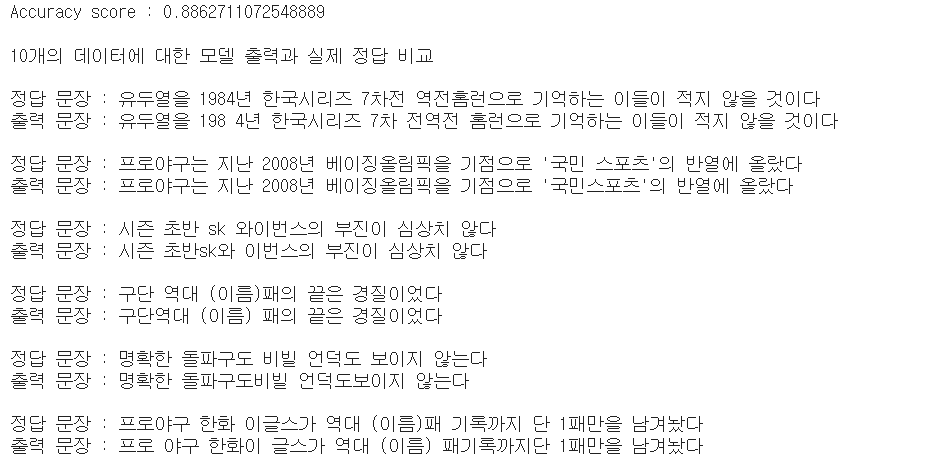
0.8862711072548889 -> 0.8863378495628379 으로 약 0.00006674 상승